In [116]:
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score
)

In [64]:
df1 = pd.read_csv("f1_2022_2023_train.csv")
df2 = pd.read_csv("f1_2024_test.csv")

# Stack them vertically
df = pd.concat([df1, df2], axis=0)

print(f"Base data has {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Base data has 1017 rows and 59 columns


,Driver.code,air_temp_mid,avg_lap_time,avg_tyre_life,constructor,driver,driverId,finishing_position,grid_position,humidity_mid,...,Q2_sec,Q3_sec,Q1_sec_filled,Q2_sec_filled,Q3_sec_filled,Q1_gap,Q2_gap,Q3_gap,flg_podium,flg_top5
0,ALB,23.2,101.569843,19.00,Williams,ALB,albon,13.0,14.0,37,...,92.664,NaN,92.726,92.664,113.841,27.610,27.713,49.450,0,0
1,ALO,23.2,102.109941,14.25,Alpine,ALO,alonso,9.0,8.0,37,...,91.621,92.195,92.346,91.621,92.195,27.230,26.670,27.804,0,0
2,BOT,23.2,101.061882,19.00,Alfa Romeo,BOT,bottas,6.0,6.0,37,...,91.717,91.560,91.919,91.717,91.560,26.803,26.766,27.169,0,0
3,GAS,23.2,99.646250,15.00,AlphaTauri,GAS,gasly,20.0,10.0,37,...,91.635,92.338,92.096,91.635,92.338,26.980,26.684,27.947,0,0
4,HAM,23.2,101.586803,14.25,Mercedes,HAM,hamilton,3.0,5.0,37,...,91.048,91.238,92.285,91.048,91.238,27.169,26.097,26.847,1,1


In [65]:
# select features
#   a) keep all non-target columns, or
#   b) explicitly list the ones we want.

feature_cols = ['Q1_gap', 'pitted', 
                'weather_precip_total', 'weather_airTemp_mean', 
                'qualifying_round_reached', 
                'humidity_mid', 'pit_min_duration_sec', 
                'lapTime_std_sec', 'Q2_sec_filled', 'race_name', 
                'pit_avg_duration_sec', 'weather_wind_mean', 
                'Q3_gap', 'pit_last_lap', 'Q3_sec_filled', 
                'weather_humidity_mean', 'multi_stop', 
                'track_temp_mid', 'avg_tyre_life', 'Q2_gap', 
                'weather_pressure_mean', 'pit_total_duration_sec', 
                'avg_lap_time', 'grid_position', 'made_Q3', 
                'laps_count', 'made_Q2', 'air_temp_mid', 
                'one_stop', 'weather_airTemp_max', 
                'lapTime_best_sec', 'lapTime_mean_sec', 
                'qualiPosition', 'pit_first_lap', 
                'eliminated_in_Q3', 'eliminated_in_Q2', 
                'eliminated_in_Q1', 'flg_podium', 'laps_total', 
                'num_pit_stops', 'Q1_sec_filled', 'round', 
                'pit_stop_count', 'weather_airTemp_min']


In [66]:
# keep only existing columns to avoid key errors
feature_cols = [c for c in feature_cols if c in df.columns]

In [67]:
ml_dataset = df[feature_cols].copy()
print(f"Working dataset has {ml_dataset.shape[0]} rows and {ml_dataset.shape[1]} columns")

Working dataset has 1017 rows and 44 columns


In [68]:
# coerce types and preprocessing
def coerce_to_unicode(x):
    if sys.version_info < (3, 0):
        if isinstance(x, str):
            return unicode(x, "utf-8")
        else:
            return unicode(x)
    else:
        return str(x)

# split into cats / nums like in DSS
categorical_features = [
    "pitted", "race_name", "multi_stop",
    "grid_position_group",
    "driver", "team",
    "eliminated_in_Q3", "eliminated_in_Q2", "eliminated_in_Q1",
]
categorical_features = [c for c in categorical_features if c in ml_dataset.columns]

numerical_features = [c for c in feature_cols if c not in categorical_features]


In [69]:
# cast types
for feat in categorical_features:
    ml_dataset[feat] = ml_dataset[feat].apply(coerce_to_unicode)

for feat in numerical_features:
    ml_dataset[feat] = ml_dataset[feat].astype("float64")

In [70]:
# stratified train/test split (80/20)
train, test = train_test_split(
    ml_dataset,
    test_size=0.2,
    random_state=1337,
    stratify=ml_dataset["flg_podium"]
)

print(f"Train data: {train.shape}")
print(f"Test  data: {test.shape}")

Train data: (813, 44)
Test  data: (204, 44)


In [88]:
X_train = train.drop(columns=["flg_podium"])
X_test  = test.drop(columns=["flg_podium"])

y_train = train["flg_podium"].astype(int).to_numpy().ravel()
y_test  = test["flg_podium"].astype(int).to_numpy().ravel()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train: (813, 43)
y_train: (813,)
X_test : (204, 43)
y_test : (204,)


In [89]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 37
Categorical features: 6


In [90]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", max_categories=100))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [127]:
models = {}

# L1 Logistic Regression (similar to what you had in Dataiku)
models["logit_l1"] = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=1337,
    max_iter=1000
)

# Random Forest
models["rf"] = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=1337,
    n_jobs=-1
)

# XGBoost (if available)
models["xgb"] = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=1337
)

# MLP classifier (NN)
models["mlp"] = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=300,
    random_state=1337
)


In [92]:
results = []

for name, clf in models.items():
    print(f"Training model: {name}")
    
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", clf)
    ])
    
    pipe.fit(X_train, y_train)
    
    # Predict probabilities if available
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        if hasattr(pipe.named_steps["clf"], "decision_function"):
            scores = pipe.decision_function(X_test)
            # convert scores to pseudo-probas via ranking-based monotone transform
            # but for AUC we can just use scores directly:
            auc = roc_auc_score(y_test, scores)
        else:
            auc = np.nan  
    
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        "model": name,
        "ROC_AUC": auc,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "F1": f1
    })

results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
results_df

Training model: logit_l1
Training model: rf
Training model: xgb
Training model: mlp


,model,ROC_AUC,accuracy,precision,recall,F1
0,logit_l1,0.939773,0.887255,0.586957,0.870968,0.701299
2,xgb,0.920007,0.897059,0.750000,0.483871,0.588235
1,rf,0.910591,0.901961,0.789474,0.483871,0.600000
3,mlp,0.901734,0.897059,0.666667,0.645161,0.655738


The chosen model then is logit.

In [100]:
from sklearn.calibration import CalibratedClassifierCV

logit_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=1337,
    max_iter=1000
)

base_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", logit_l1)
])

# Wrap the pipeline in a calibrator with CV
calibrated_logit = CalibratedClassifierCV(
    estimator=base_pipe,
    cv=5,           # 5-fold calibration
    method="sigmoid"
)

calibrated_logit.fit(X_train, y_train)

y_proba = calibrated_logit.predict_proba(X_test)[:, 1]
y_pred  = calibrated_logit.predict(X_test)

print("ROC–AUC :", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("F1       :", f1_score(y_test, y_pred, zero_division=0))

ROC–AUC : 0.9392131269811672
Accuracy: 0.9264705882352942
Precision: 0.9
Recall   : 0.5806451612903226
F1       : 0.7058823529411765


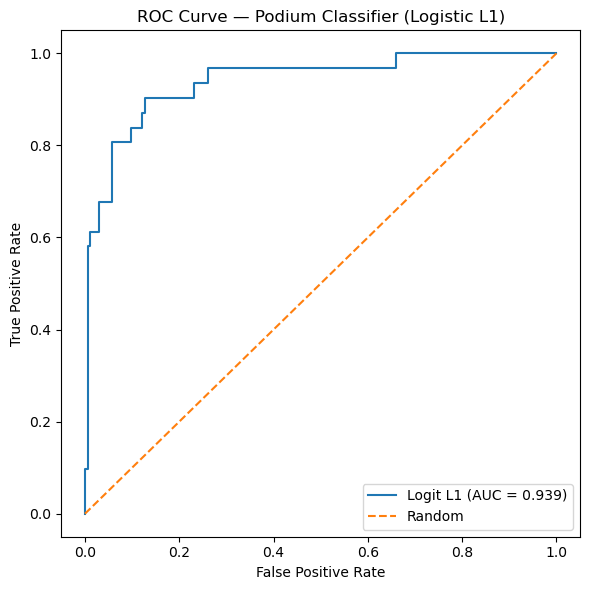

ROC–AUC: 0.9392131269811672


In [118]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Logit L1 (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Podium Classifier (Logistic L1)")
plt.legend()
plt.tight_layout()
plt.show()

print("ROC–AUC:", auc)

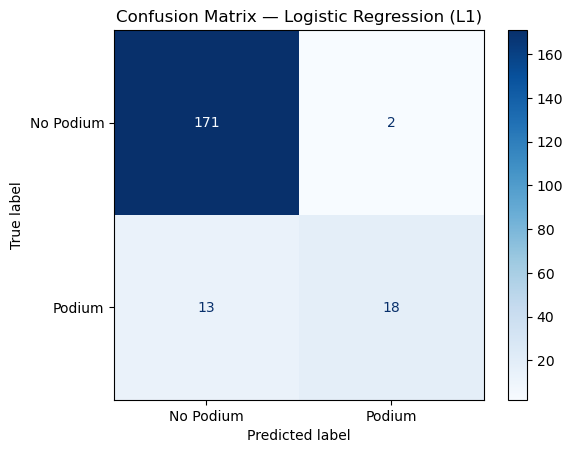

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Podium", "Podium"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (L1)")
plt.show()

In [121]:
# Build a small evaluation dataframe
eval_df = pd.DataFrame({
    "y": y_test,
    "score": y_proba
})

# Sort by predicted probability descending
eval_df = eval_df.sort_values("score", ascending=False).reset_index(drop=True)

# Overall podium rate (baseline)
base_rate = eval_df["y"].mean()
print(f"Baseline podium rate in test set: {base_rate:.3%}")

Baseline podium rate in test set: 15.196%


In [123]:
top_frac = 0.10
n_top = int(len(eval_df) * top_frac)

top_df = eval_df.iloc[:n_top]
top_rate = top_df["y"].mean()
lift_top10 = top_rate / base_rate

print(f"Podium rate in top 10% highest scores: {top_rate:.3%}")
print(f"Lift at top 10%: {lift_top10:.2f}x baseline")

Podium rate in top 10% highest scores: 90.000%
Lift at top 10%: 5.92x baseline


In [125]:
# Create deciles based on rank
eval_df["decile"] = pd.qcut(
    eval_df.index,
    q=10,
    labels=False
)  # 0 = top 10%, 9 = bottom 10%

lift_table = (
    eval_df.groupby("decile")
           .agg(
               n=("y", "size"),
               podiums=("y", "sum"),
               response_rate=("y", "mean"),
               avg_score=("score", "mean")
           )
           .sort_index()
)

lift_table["lift"] = lift_table["response_rate"] / base_rate
lift_table

,n,podiums,response_rate,avg_score,lift
decile,,,,,
0,21,19,0.904762,0.619480,5.953917
1,20,6,0.300000,0.373480,1.974194
2,20,3,0.150000,0.176407,0.987097
3,21,2,0.095238,0.109307,0.626728
4,20,0,0.000000,0.061840,0.000000
5,20,0,0.000000,0.032954,0.000000
6,21,0,0.000000,0.016376,0.000000
7,20,1,0.050000,0.005512,0.329032
8,20,0,0.000000,0.001639,0.000000


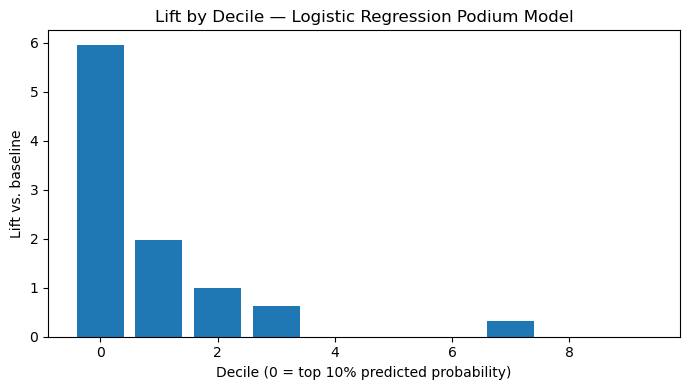

In [126]:
plt.figure(figsize=(7, 4))
plt.bar(lift_table.index, lift_table["lift"])
plt.xlabel("Decile (0 = top 10% predicted probability)")
plt.ylabel("Lift vs. baseline")
plt.title("Lift by Decile — Logistic Regression Podium Model")
plt.tight_layout()
plt.show()

In [110]:
def get_feature_names(preprocessor):
    """Extract final feature names from column transformer."""
    output_features = []

    for name, transformer, cols in preprocessor.transformers_:

        if name == "drop":
            continue

        if hasattr(transformer, "get_feature_names_out"):
            fts = list(transformer.get_feature_names_out(cols))
            output_features.extend(fts)

        elif hasattr(transformer, "named_steps"):
            # For pipelines inside ColumnTransformer
            inner = transformer.named_steps.get("onehot") or transformer.named_steps.get("scaler")
            if inner and hasattr(inner, "get_feature_names_out"):
                fts = list(inner.get_feature_names_out(cols))
                output_features.extend(fts)
            else:
                output_features.extend(cols)

        else:
            output_features.extend(cols)

    return output_features

In [111]:
# Feature names AFTER preprocessing
feature_names = get_feature_names(preprocessor)

# L1 logistic regression coefficients
coefs = logit_pipe.named_steps["clf"].coef_.flatten()

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
})

# Sort by importance strength
feat_imp_sorted = feat_imp.sort_values("abs_coef", ascending=False)
feat_imp_sorted.head(15)

,feature,coef,abs_coef
7,Q2_sec_filled,3.169692,3.169692
23,made_Q2,3.052668,3.052668
35,pit_stop_count,2.026101,2.026101
32,num_pit_stops,-1.882057,1.882057
20,grid_position,-1.816627,1.816627
29,qualiPosition,-1.707496,1.707496
67,eliminated_in_Q2_False,-1.561164,1.561164
33,Q1_sec_filled,-1.011041,1.011041
19,avg_lap_time,-0.886658,0.886658
60,race_name_Spanish Grand Prix,0.770396,0.770396
